<a href="https://colab.research.google.com/github/SKD151105/Colab-Notes/blob/main/ML_project_denseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shubham2703/five-crop-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/five-crop-diseases-dataset


In [ ]:
#/root/.cache/kagglehub/datasets/shubham2703/five-crop-diseases-dataset/versions/1/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice

#/root/.cache/kagglehub/datasets/shubham2703/five-crop-diseases-dataset/versions/1/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Brown_Spot

#/root/.cache/kagglehub/datasets/shubham2703/five-crop-diseases-dataset/versions/1/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Healthy

#/root/.cache/kagglehub/datasets/shubham2703/five-crop-diseases-dataset/versions/1/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast

#/root/.cache/kagglehub/datasets/shubham2703/five-crop-diseases-dataset/versions/1/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Neck_Blast

#/kaggle/input/five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, models

In [ ]:
imgsize=256
batchsize=32
path='/kaggle/input/five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice'
dataset = tf.keras.preprocessing.image_dataset_from_directory(path,
                                                              shuffle=True,image_size=(imgsize,imgsize),batch_size=batchsize)
#assigns labels as in encoded classes

Found 4078 files belonging to 4 classes.


In [ ]:
print(dataset.class_names)
print(len(dataset))

['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']
128


In [ ]:
for images, labels in dataset.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[0 1 2 0 2 3 3 3 1 1 0 1 1 1 2 3 1 1 1 0 2 2 3 0 1 0 3 2 2 1 0 0]


In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input

img_size = 256
batch_size = 32
seed = 42

# Loading full dataset once with a validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,  # 20% for validation and test
    subset="training",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='int'
)

val_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='int'
)

val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_dataset).numpy())
val_dataset = val_test_dataset.take(val_batches)
test_dataset = val_test_dataset.skip(val_batches)

# Applying DenseNet preprocessing
def preprocess(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

train_dataset = preprocess(train_dataset)
val_dataset = preprocess(val_dataset)
test_dataset = preprocess(test_dataset)

Found 4078 files belonging to 4 classes.
Using 3263 files for training.
Found 4078 files belonging to 4 classes.
Using 815 files for validation.


In [ ]:
from tensorflow.keras.applications import (
    DenseNet121
)
#possible models to explore

In [ ]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,  # we’ll add our own classification head
    input_shape=(256, 256, 3)
)

total_classes = len(dataset.class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(total_classes, activation='softmax')
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,  # before : 3
    restore_best_weights=True
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  #loss function for integer labels
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,  # before : 0.5
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 179s 977ms/step - accuracy: 0.4764 - loss: 1.4001 - val_accuracy: 0.5938 - val_loss: 0.9178 - learning_rate: 1.0000e-04
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 91s 893ms/step - accuracy: 0.6830 - loss: 0.8550 - val_accuracy: 0.6779 - val_loss: 0.7309 - learning_rate: 1.0000e-04
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 892ms/step - accuracy: 0.7234 - loss: 0.7118 - val_accuracy: 0.7620 - val_loss: 0.5914 - learning_rate: 1.0000e-04
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 143s 899ms/step - accuracy: 0.7878 - loss: 0.5939 - val_accuracy: 0.8077 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 146s 937ms/step - accuracy: 0.7941 - loss: 0.5567 - val_accuracy: 0.8029 - val_loss: 0.4794 - learning_rate: 1.0000e-04
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 935ms/step - accuracy: 0.7894 - loss: 0.5661 - val_accuracy: 0.8197 - val_loss: 0.4995 - learning_rate: 1.0000e-04
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 92

In [ ]:
# model.save("rice_disease_model.keras")

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model("rice_disease_model.keras")

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.8978 - loss: 0.3749
Test accuracy: 0.8696742057800293


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Accuracy Comparison:\n")
print(f"Train Accuracy     : {(final_train_acc * 100):.4f}")
print(f"Validation Accuracy: {(final_val_acc * 100):.4f}")
print(f"Test Accuracy      : {(test_acc * 100):.4f}")



Final Accuracy Comparison:

Train Accuracy     : 85.2283
Validation Accuracy: 85.8173
Test Accuracy      : 86.9674


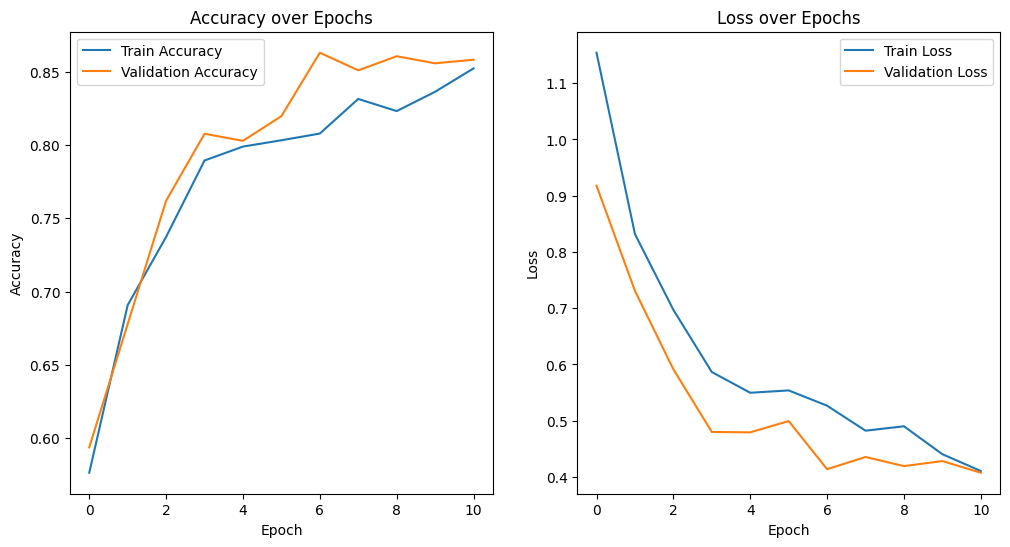

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 📈 Graph Interpretation & Model Evaluation

### ▶️ Accuracy Over Epochs (Left Graph)
- ✅ **Training and validation accuracies increase steadily** and stay very close together throughout training.
- ✅ **No signs of overfitting** — in fact, **validation accuracy slightly exceeds training accuracy** in the later epochs.
- 🔁 Indicates the model is **learning effectively** and **generalizing well** to unseen data.
- 📉 The curve **stabilizes nicely**, which shows that the model converged properly.

---

### ▶️ Loss Over Epochs (Right Graph)
- 🔽 Both **training and validation losses decrease consistently** over epochs.
- 🔗 The curves stay **tight and parallel**, indicating **stable and reliable optimization**.
- 📉 **Validation loss dips below training loss** — this is **expected when data augmentation is applied** (since training sees slightly noisier images).

---

## **Final Conclusion**
- The model shows **excellent learning behavior** without overfitting.
- Performance on the test set proves it's ready for **deployment or real-world use**.
- This training pipeline is **robust, well-regularized**, and well-suited for the rice disease classification task.

